<center><h1> Προπαρασκευή 3ου εργαστηρίου</h1></center>

Επειδή ο κώδικας ήταν οργανωμένος σε συγκεκριμένα αρχεία και η εκτελεσή του δεν γινόταν μέσω jupyter notebook στη αναφορά δεν περιέχεται ο περισσότερος κώδικας που συμπληρώθηκε. Η αναφορά στοχεύει στην εξήγηση του, την παρουσίαση των αποτελεσμάτων και στην απάντηση των ζητούμενων ερωτήσεων. 

<center> <h2> Εισαγωγή </h2></center>

Σκοπός της προπαρασκευής είναι η υλοποίηση ενός μοντέλου για την επεξεργασία και κατηγοριοποίηση κειμένων, με την χρήση βαθιών νευρωνικών δικτύων (Deep Neural Networks - DNN). Για την ανάπτυξη των μοντέλων χρησιμοποιήθηκε η βιβλιοθήκη PyTorch. Αρχικά, χρησιμοποιώντας προ-εκπαιδευμένες
διανυσματικές αναπαραστάσεις λέξεων (pretrained word embeddings), θα δημιουργήσουμε
αναπαραστάσεις για κάθε κείμενο. Στη συνέχεια, θα χρησιμοποιήσουμε τις αναπαραστάσεις των
κειμένων, ώστε να κάνουμε την κατηγοριοποίηση. Στόχος είναι να εκπαιδεύσουμε μοντέλα, τα οποία
θα μπορούν να κάνουν ανάλυση συναισθήματος (sentiment analysis) σε προτάσεις. Μας παρέχονται
2 σύνολα δεδομένων .
- Sentence Polarity Dataset 2 [Pang and Lee, 2005]. To dataset αυτό περιέχει 5331 θετικές
και 5331 αρνητικές κριτικές ταινιών, από το Rotten Tomatoes και είναι binary-classification
πρόβλημα (positive, negative).
- Semeval 2017 Task4-A 3 [Rosenthal et al., 2017]. To dataset αυτό περιέχει tweets τα οποία
είναι κατηγοριοποιημένα σε 3 κλάσεις (positive, negative, neutral) με 49570 παραδείγματα
εκπαίδευσης και 12284 παραδείγματα αξιολόγησης.

<center><h2> Επιλογή pretrained word embeddings </h2></center>

Για την συγκεκριμένη άσκηση θα χρησιμοποιηθούν τα παρακάτω embeddings:
- Glove embeddings το οποίο περιέχει ακόμα και 50-διάστατα embeddings έχοντας έτσι λιγότερες υπολογιστικές απαιτήσεις.
- FastText embeddings τα οποία όμως είναι διαθέσιμα μόνο σε 300 διαστάσεις.

Σε όλη την παρακάτω ανάλυση χρησιμοποιήθηκαν τα glove embeddings των 50 διαστάσεων. Στο τέλος θα παρουσιαστεί η επίδοση του μοντέλου και σε άλλα embeddings. 

<center><h2> 1. Προεπεξεργασία Δεδομένων </h2></center>

Για την προεπεξεργασία των δεδομένων μας θα κληρονομήσουμε τις κλάσεις __torch.utils.data.Dataset__ και __torch.utils.data.Dataloader__ του pytorch. Συγκεκριμένα, η πρώτη μετατρέπει κάθε παράδειγμα στην μορφή που απαιτείται για την εκπαίδευση του νερωνικού δικτύου ενώ η δεύτερη χρησιμοποιώντας ένα στιγμιότυπο της κλάσης Dataset μετατρέπει τα παραδείγματα σε torch Tensors και τα οργανώνει σε mini-batches.

### 1.1 Κωδικοποίηση επισημειώσεων (Labels)

Σε αυτό το στάδιο θα μετατρέψουμε τα labels από κείμενα (positive, neutral, negative για το Semeval2017A dataset και positive, negative για το MR dataset) σε αριθμούς ώστε να μπορούν να εισαχθούν μετά στο νευρωνικό δίκτυο. Η μετατροπή αυτή γίνεται χρησιμοποιώντας το LabelEncoder του sklearn όπως φαίνεται και παρακάτω σε μία τυχαία λίστα από labels.

In [1]:
from numpy.random import choice
from sklearn.preprocessing import LabelEncoder

# Generate 10 random labels. 
labels = choice(['positive', 'negative'], 10)
print(labels)
# Create a new label encoder.
le = LabelEncoder()
# Encode labels
encoded_labels = le.fit_transform(labels) 
print(encoded_labels)
# compute number of classes made by the encoder
n_classes = le.classes_.size
print(n_classes)

['positive' 'negative' 'negative' 'negative' 'positive' 'positive'
 'negative' 'positive' 'negative' 'negative']
[1 0 0 0 1 1 0 1 0 0]
2


Παρακάτω βλέπουμε τα πρώτα 10 labels από τα δεδομένα εκπαίδευσης και την αντιστοιχία τους σε αριθμούς για το MR dataset.

<img src="photos/EX1_MR.png">

Παρακάτω βλέπουμε τα πρώτα 10 labels από τα δεδομένα εκπαίδευσης και την αντιστοιχία τους σε αριθμούς για το Semevel2017A dataset.

<img src="photos/EX1_Sem.png">

### 1.2 Λεκτική Ανάλυση (Tokenization)

Στη συνέχεια πρέπει να μετατρέψουμε τα δεδομένα μας από κείμενα σε ακολουθίες από tokens. Αυτό θα συμβεί στην αρχικοποίηση της κλάσης __SentenceDataset__ η οποία κληρονομεί την κλάση torch.utils.data.Dataset. Ανάλογα με τις ιδιαιτερότητες του dataset μας μπορούμε να χρησιμοποιήσουμε διαφορετικούς tokenizers. Για το MR dataset που δεν είναι σε τόσο "κακή" μορφή τα κείμενα (σε σχέση με τα tweets) μπορούμε να κάνουμε κάποιο απλό tokenize χωρίς την χρήση κάποιας βιβλιοθήκης. Αντίθετα, για το Semeval 2017A dataset που περιέχει tweets θα χρησιμοποιήσουμε τον TweetTokenizer του nltk. Παρακάτω φαίνεται η χρήση τους στην πρώτη πρόταση από κάθε dataset.

- #### Sentence Polarity dataset

In [2]:
import string
from nltk.corpus import stopwords
# sample review
text = "the gorgeously elaborate continuation of ' the lord of the rings ' trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth"
# split into tokens by white space
tokens = text.split()
# remove punctuation from each token
table = str.maketrans('', '', string.punctuation)
tokens = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
tokens = [word for word in tokens if word.isalpha()]
# filter out stop words
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
# filter out short tokens
tokens = [word for word in tokens if len(word) > 1]
print(tokens)

['gorgeously', 'elaborate', 'continuation', 'lord', 'rings', 'trilogy', 'huge', 'column', 'words', 'cannot', 'adequately', 'describe', 'cowriterdirector', 'peter', 'jacksons', 'expanded', 'vision', 'tolkiens', 'middleearth']


- #### Semeval 2017A dataset

In [3]:
from nltk.tokenize import TweetTokenizer
# sample tweet
text = "ang sarap mging panganay. Pag ikaw may kylngan wala kang matakbuhan.:D 101 #realtalk #grind #onyourown"
tweetToken = TweetTokenizer()
tokens = tweetToken.tokenize(text)
print(tokens)

['ang', 'sarap', 'mging', 'panganay', '.', 'Pag', 'ikaw', 'may', 'kylngan', 'wala', 'kang', 'matakbuhan', '.', ':D', '101', '#realtalk', '#grind', '#onyourown']


Παρακάτω βλέπουμε τα πρώτα 10 tokenized παραδείγματα από τα δεδομένα εκπαίδευσης για το MR dataset.

<img src="photos/EX2_MR.png">

Παρακάτω βλέπουμε τα πρώτα 10 tokenized παραδείγματα από τα δεδομένα εκπαίδευσης για το Semeval2017A dataset.

<img src="photos/EX2_Sem.png">

### 1.3 Κωδικοποίηση Παραδειγμάτων (Λέξεων)

Τώρα πρέπει να υλοποιήσουμε την μέθοδο \__getitem__ της παραπάνω κλάσης η οποία δέχεται ένα index και επιστρέφει τα εξής:
- την κωδικοποιημένη μορφή μίας πρότασης (αντιστοίχηση token στο id του embedding)
- το id της επισημείωσης 
- το πραγματικό μήκος της πρότασης (δηλαδή εξαιρουμένων των μηδενικών στοιχείων)
Αρχικά, επειδή πρέπει όλα τα παραδείγματα να έχουν ίδιο μήκος πρέπει να βρούμε ένα κατάλληλο μήκος που να καλύπτει την πλειοψηφία των προτάσεων, αγνοώντας τους outliers. Παρακάτω βλέπουμε το scatterplot του μεγέθους όλων των προτάσεων.

loading word embeddings...
Loaded word embeddings from cache.


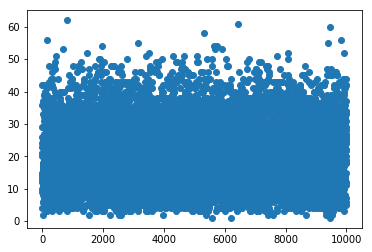

In [10]:
%run bestLength.py MR

loading word embeddings...
Loaded word embeddings from cache.


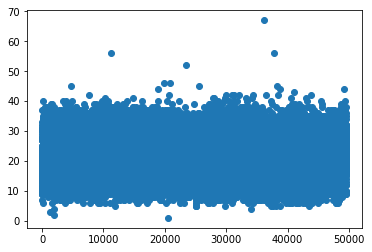

In [5]:
%run bestLength.py Semeval2017A

Μπορούμε για να ελέγξουμε ότι ο κώδικας είναι σωστός για ένα ενδεικτικό word2idx.

In [6]:
import numpy as np
# A sample word2idx.
word2idx = {'I':3, 'love':5, 'hate':4, 'this':2, 'movie':1, 'cat':6, '<unk>':0}
# A sample tokenized text
text = ['I', 'love', 'this', 'movie', 'a', 'lot']
# Length that should match
bestLength = 8
# Initialize the ndarray that will contain the encoded form of a sentence.
example = np.zeros(bestLength)
for i in range(min(bestLength, len(text))):
    if text[i] in word2idx:
        example[i] = word2idx[text[i]]
    else:
        example[i] = word2idx["<unk>"]
label = 1
length = len(text)
# print the results
print(example)
print(label)
print(length)

[3. 5. 2. 1. 0. 0. 0. 0.]
1
6


Παρατηρήσαμε στο scatterplot ότι ένα καλό μέγεθος είναι το 50 για το MR dataset και το 40 για το Semeval2017A dataset. Αφού υλοποιήσουμε λοιπόν την ζητούμενη μέθοδο (αναλυτικά σχόλια υπάρχουν στον κώδικα) όπως παραπάνω βλέπουμε παρακάτω 5 παραδέιγματα στην αρχική τους μορφή και όπως τα επιστρέφει η κλάση SentenceDataset για κάθε ένα dataset.

- __MR dataset__

<img src="photos/EX3_1_MR.png">

<img src="photos/EX3_2_MR
.png">

<img src="photos/EX3_3_MR.png">

<img src="photos/EX3_4_MR.png">

<img src="photos/EX3_5_MR.png">

- __Semeval 2017A dataset__

<img src="photos/EX3_1_Sem.png">

<img src="photos/EX3_2_Sem.png">

<img src="photos/EX3_3_Sem.png">

<img src="photos/EX3_4_Sem.png">

<img src="photos/EX3_5_Sem.png">

<center><h2> 2. Μοντέλο </h2></center>

Σε αυτό το βήμα θα σχεδιάσουμε ένα νευρωνικό δίκτυο, το οποίο:
- Θα δημιουργεί μία συνεχή διανυσματική αναπαράσταση για κάθε όρο σε μία πρόταση με την χρήση ενός Embedding layer,
- Θα δημιουργεί μία διανυσματική αναπαράσταση για όλο το κείμενο ενός παραδείγματος,
- Θα κατηγοριοποιεί το κείμενο βάση της αναπαράστασης του στην σωστή κλάση.

Ο πηγαίος κώδικας του μοντέλου βρίσκεται στο αρχείο models.py. Στη μέθοδο init θα δηλώσουμε τα layers του δικτύου και θα αρχικοποιήσουμε τα βάρη τους. Στη μέθοδο forward θα ορίσουμε τους μετασχηματισμούς των δεδομένων εισόδου για την παραγωγή της τελικής εξόδου του μοντέλου (forward pass).

### 2.1 Embedding Layer

Στο στάδιο αυτό θα δημιουργήσουμε το embedding layer το οποίο παίρνει κάθε όρο/λέξη το προβάλλει σε ένα συνεχή χώρο (embedding space) στον οποίο βρίσκονται κοντά οι νοηματικά κοντινές λέξεις.Τα βάρη του embedding layer μπορούμε να τα αρχικοποιήσουμε με τυχαίες τιμές και να τα ενημερώσουμε κατά την εκπαίδευση του μοντέλου ή να τα αρχικοποιήσουμε από προ-εκπαιδευμένα word embeddings. Εμείς θα κάνουμε το δεύτερο χρησιμοποιώντας τα embeddings που βρίσκονται στον φάκελο /embeddings και συγκεκριμένα τα 50-dimensional Glove embeddings.

Ελέγχουμε παρακάτω τον κώδικα για την δημιουργία του embedding layer.

In [7]:
# ----------------------- #
# Embedding layer testing #
# ----------------------- #
import torch
import torch.nn as nn
max_length = 6
n_embeddings = 4
embedding_size = 5
# Define a sample embedding array 
embeddings = np.array([[0, 1, 2, 3, 4],[0, 2, 4, 6, 8], [1, 3, 5, 7, 9], [4, 3, 2, 1, 0]])
print("Embeddings shape is: ", embeddings.shape)
print("Embedding array is: ", embeddings)
# Define a embedding layer
embed = nn.Embedding(num_embeddings = n_embeddings, embedding_dim = embedding_size)
# Initialize the weights of the embedding layer with embeddings array.
embed.load_state_dict({'weight': torch.from_numpy(embeddings)})
# Make embedding layer non-trainable
embed.weight.requires_grad = False
# create batch with some data
x = torch.from_numpy(np.array([[3, 0, 0, 1, 2, 1], [0, 1, 2, 3, 1, 0]])).long()
print("Input batch shape is: ", x.shape)
print("Input batch is: ", x)
# pass it through the embedding layer
embeddings = embed(x)
print("Output of embedding layer has shape: ", embeddings.shape)
print("Output of embedding layer is: ", embeddings)

Embeddings shape is:  (4, 5)
Embedding array is:  [[0 1 2 3 4]
 [0 2 4 6 8]
 [1 3 5 7 9]
 [4 3 2 1 0]]
Input batch shape is:  torch.Size([2, 6])
Input batch is:  tensor([[3, 0, 0, 1, 2, 1],
        [0, 1, 2, 3, 1, 0]])
Output of embedding layer has shape:  torch.Size([2, 6, 5])
Output of embedding layer is:  tensor([[[4., 3., 2., 1., 0.],
         [0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.],
         [0., 2., 4., 6., 8.],
         [1., 3., 5., 7., 9.],
         [0., 2., 4., 6., 8.]],

        [[0., 1., 2., 3., 4.],
         [0., 2., 4., 6., 8.],
         [1., 3., 5., 7., 9.],
         [4., 3., 2., 1., 0.],
         [0., 2., 4., 6., 8.],
         [0., 1., 2., 3., 4.]]])


#### Ερώτηση 1: Γιατί αρχικοποιούμε το embedding layer με τα προ-εκπαιδευμένα word embeddings?

Αυτό συμβαίνει διότι θέλουμε από την αρχή τα embeddings να μην είναι τυχαία. Έτσι, διευκολύνουμε το νευρωνικό μας
στο να συγκλίνει κάπου και κάνουμε την εκπαίδευση πιο γρήγορη. Αν αρχικοποιούσαμε το embedding layer με τυχαίες τιμές και το αφήναμε να εκπαιδευτεί κατα το training τότε θα ηταν πολύ πιο δύσκολο για το νευρωνικό να βρει ένα μοτίβο σε αυτά τα unstructered δεδομένα που θα αναπαρηστούν τις λέξεις εντελώς τυχαία στο χώρο. Τα προ-εκπαιδευμένα embeddings τώρα επειδή αναπαριστούν τις λέξεις σε ένα χώρο όπου η σημασιολογικά κοντά λέξεις είναι και κοντά σε αυτό το χώρο (από πλευρά απόστασης) δίνουν στο νευρωνικά πιο δομημένα τα δεδομένα και την πληροφορία ώστε αυτό να εκπαιδευτεί ευκολότερα σε αυτά και να συγκλίνει κάπου.

#### Ερώτηση 2: Γιατί κρατάμε παγωμένα τα βάρη του embedding layer κατά την εκπαίδευση?

Κατά την εκπαίδευση κρατάμε παγωμένα τα βάρη του embedding layer για τους εξής δύο λόγους:
- Για να αποφύγουμε το overfitting το οποίο είναι πολύ πιθανό να συμβεί αν εκτός από το νευρωνικό είχαμε και τις
αναπαραστάσεις που μπαίνουν σε αυτό να εκπαιδεύονται πάνω στο training set μας. Αυτό θα εμποδίσει τον αλγόριθμο στο να γενικεύσει και θα καταλήξουμε με ένα μοντέλο που απλά έχει μάθει πάρα πολύ καλά τα δεδομένα που του δώσαμε.
- Για να μειώσουμε τις συνολικές παραμέτρους του μοντέλου μας κερδίζοντας έτσι σε υπολογιστική πολυπλοκότητα.


### 2.2 Output Layer(s)

Στη συνέχεια, πρέπει να θα πρέπει να προβάλουμε τις αναπαραστάσεις των κειμένων στο χώρο των κλάσεων. Αυτό θα συμβεί σε δύο στάδια. Αρχικά, θα έχουμε ένα layer με μία μη γραμμική συνάρτηση ενεργοποίησης (relu) και στη συνέχεια θα έχουμε το τελευταίο layer το οποίο θα προβάλει τις τελικές αναπαραστάσεις στον χώρο των κλάσεων.

In [8]:
import torch
import torch.nn as nn
# 2dim tensor.. aka a matrix
batch_size = 16
feature_size = 5
x = torch.randn(batch_size, feature_size)
# now let's try out some NN layer
output_size = 3
fc = nn.Linear(feature_size, output_size)
print(fc(x).shape)

torch.Size([16, 3])


#### Ερώτηση 3: Γιατί βάζουμε μία μη γραμμική συνάρτηση ενεργοποίησης στο προτελευταίο layer? Τι διαφορά θα είχε αν είχαμε 2 ή περισσότερους γραμμικούς μετασχηματισμούς στη σειρά?

Η εισαγωγή μιας μη γραμμικής συνάρτησης ενεργοποιήσης στο προτελευταίο layer γίνεται ώστε να εισάγουμε την μη
γραμμικότητα στο μοντέλο και να του δώσουμε την δυνατότητα να κατασκευάζει και μη γραμμικές συναρτήσεις για να
περιγράψει την είσοδο. Αν απλά είχαμε 2 ή περισσότερους γραμμικούς μετασχηματισμούς στη σειρά τότε αυτό θα ισοδυναμούσε με ένα απλό perceptron αφού το γινόμενο γραμμικών συναρτήσεων κάνει γραμμική συνάρτηση. Το μοντέλο μας λοιπόν θα προσπαθούσε να περιγράψει την είσοδό του χρησιμοποιώντας μόνο γραμμικές συναρτήσεις (όπως σε ένα απλό logistic regression μοντέλο) και έτσι θα καταλήγαμε με ένα πολύ φτωχό μοντέλο.

### 2.3 Forward pass

Στο σημείο αυτό θα κάνουμε το forward propagation, δηλαδή θα σχεδιάσουμε τον τρόπο με τον οποίο το μοντέλο μας
θα μετασχηματίζει μία είσοδο που του δίνουμε στην αντίστοιχη έξοδο. Η είσοδος στο μοντέλο θα είναι ένα mini-batch
με διαστάσεις (batch_size, max_length). Η έξοδος θα προκύπτει ως εξής:
- Αρχικά, περνάμε τiς λέξεις κάθε πρότασης από το embedding layer ώστε να αντιστοιχηθεί κάθε όρος σε ένα διάνυσμα. 
- Μετά, πρέπει να δημιουργήσουμε από τις επιμέρους αναπαραστάσεις των όρων μία ενιαία για κάθε πρόταση. Αυτό θα γίνει υπολογίζοντας των μέσο όρων των embeddings σε μία πρόταση.
- Το επόμενο βήμα είναι να εφαρμόσουμε τον μη γραμμικό μετασχηματισμό μας στην παραπάνω αναπαράσταση.
- Τέλος, προβάλλουμε την τελική αναπαράσταση στον χώρο των κλάσεων.

Επειδή όλα τα παραπάνω είναι αρκετές λειτουργίες εφαρμόζουμε όλα τα παραπάνω για ένα δικό μας μικρό mini-batch λέξεων όπως φαίνεται παρακάτω. Ένας αντίστοιχος κώδικας συμπληρώθηκε και στο αρχείο models.py

In [9]:
# -------------------- #
# Forward pass testing #
# -------------------- #
import torch
import torch.nn as nn
# Lengths definitions
max_length = 6
n_embeddings = 4
batch_size = 2
embeddings_size = 5
hidden_size = 8

# Create batch with some data
x = torch.from_numpy(np.array([[3, 0, 0, 1, 2, 1], [0, 1, 2, 3, 1, 0]])).long()
# Create the lengths array
lengths = np.array([5, 3])
print("INPUTS")
print("Input batch shape is: ", x.shape)
print("Input batch is: ", x)
print("Input lengths array is: ", lengths)

# 1. pass it through the embedding layer that we created in the 'Embedding layer' section.
embeddings = embed(x)
print("STEP 1")
print("Output of embedding layer has shape: ", embeddings.shape)
print("Output of embedding layer is: ", embeddings)

# 2. Create a representiation for each sentence by computing the mean of the word embeddings in each .
representations = torch.zeros([batch_size, embeddings_size])
for i in range(batch_size):
    representations[i] = torch.sum(embeddings[i], dim=0) / lengths[i]
print("Step 2")
print("Representation of sentences have shape: ", representations.shape)
print("Representation of sentences: ", representations)

# 3. Pass it through non linear transformation
linear1 = nn.Linear(embedding_size, hidden_size)
relu = nn.ReLU()
representations =  relu(linear1(representations))
print("Step 3")
print("Output of layer 1 have shape: ", representations.shape)
print("Output of layer 1: ", representations)
# 4 - Project the representations to classes using a linear layer
linear2 = nn.Linear(hidden_size, output_size)
logits = linear2(representations)
print("Step 4")
print("Output have shape: ", logits.shape)
print("Output: ", logits)

INPUTS
Input batch shape is:  torch.Size([2, 6])
Input batch is:  tensor([[3, 0, 0, 1, 2, 1],
        [0, 1, 2, 3, 1, 0]])
Input lengths array is:  [5 3]
STEP 1
Output of embedding layer has shape:  torch.Size([2, 6, 5])
Output of embedding layer is:  tensor([[[4., 3., 2., 1., 0.],
         [0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.],
         [0., 2., 4., 6., 8.],
         [1., 3., 5., 7., 9.],
         [0., 2., 4., 6., 8.]],

        [[0., 1., 2., 3., 4.],
         [0., 2., 4., 6., 8.],
         [1., 3., 5., 7., 9.],
         [4., 3., 2., 1., 0.],
         [0., 2., 4., 6., 8.],
         [0., 1., 2., 3., 4.]]])
Step 2
Representation of sentences have shape:  torch.Size([2, 5])
Representation of sentences:  tensor([[ 1.0000,  2.4000,  3.8000,  5.2000,  6.6000],
        [ 1.6667,  4.0000,  6.3333,  8.6667, 11.0000]])
Step 3
Output of layer 1 have shape:  torch.Size([2, 8])
Output of layer 1:  tensor([[2.4996, 0.7802, 2.0321, 0.0000, 0.0000, 3.7189, 1.2986, 0.0000],
        [4.23

#### Ερώτηση 4: Αν θεωρήσουμε ότι κάθε διάσταση του embedding χώρου αντιστοιχεί σε μία αφηρημένη έννοια, μπορείτε να δώσετε μία διαισθητική ερμηνεία για το τι περιγράφει η αναπαράσταση που φτιάξατε (κέντρο-βάρους).

Στο μοντέλο μας η αναπαράσταση μίας πρότασης προέκυψε ως το κέντρο βάρους των embeddings των λέξεων που την απαρτίζουν. Συνεπώς, η τιμή σε κάθε διάσταση της τελικής αναπαράστασης αποτελεί τον μέρο όρο των τιμών των λέξεων σε αυτή στη διάσταση. Αυτό σημαίνει, ότι αναπαράσταση μας εκφράζει μία έννοια όταν οι λέξεις που την απαρτίζουν εκφράζουν επίσης αυτήν την έννοια και αντίστοιχα δεν εκφράζει μία έννοια όταν οι λέξεις που την απαρτίζουν δεν την εκφράζουν και αυτές. Αυτό είναι σωστό προφανώς ότι δηλαδή το νόημα μιας πρότασης προκύπτει άμεσα από το νόημα των λέξεων που την απαρτίζουν, ωστόσο η αναπαράσταση αυτή δεν λαμβάνει υπόψιν της τα συντακτικά χαρακτηριστικά.

#### Ερώτηση 5: Αναφέρετε πιθανές αδυναμίες της συγκεκριμένης προσέγγισης για να αναπαραστήσουμε κείμενα. 

Η κύρια αδυναμία της συγκεκριμένης προσέγγισης είναι ότι αγνοούμε τελείως την σειρά με την οποία έρχονται οι λέξεις και απλά τις αντιμετωπίζουμε ως μέρος της πρότασης είτε βρίσκονται στην αρχή, είτε στη μέση, είτε στο τέλος. Αυτό είναι μεγάλη αδυναμία γιατί τα συντακτικά χαρακτηριστικά μιας πρότασης πολλές φορές επηρεάζουν την
σημασία της.


<center><h2> 3. Διαδικασία Εκπαίδευσης </h2></center>

Σε αυτό το βήμα θα υλοποιήσουμε την διαδικασία εκπαίδευσης του δικτύου, όπως να οργανώσουμε τα παραδείγματα σε mini-batches και να εκτελέσουμε stochastic gradient descent για να ενημερώνουμε τα βάρη του δικτύου.

### 3.1 Φόρτωση Παραδειγμάτων (DataLoaders)

Χρησιμοποιούμε την κλάση DataLoader η οποία μας επιτρέπει να χωρίζουμε το data set σε mini-batches και γενικά μας επιστρέπει λειτουργίες πάνω σε ένα set δεδομένων.

#### Ερώτηση 6: Τι συνέπειες έχουν τα μικρά και μεγάλα mini-batches στην εκπαίδευση των μοντέλων?

Το μέγεθος των mini-batches επηρεάζει την εκπαίδευση των μοντέλων μας με δύο τρόπους. Αρχικά, στο SGD όταν πηγαίνουμε να υπολογίσουμε τα gradients όσο πιο μεγάλο mini-batch έχουμε τόσο πιο κοντά είμαστε στα gradients όλου του training set και δεν έχουμε εισάγει θόρυβο στο μοντέλο μας. Αυτό όμως δεν είναι συνήθως θετικό γιατί το μοντέλο με τα μεγάλα mini-batch ίσως συγκλίνει σε κάποιο τοπικό ελάχιστο το οποίο ένα αντίστοιχο μοντέλο αλλά με μικρότερα mini-batches (επειδή ακριβώς θα είχε εισάγει θόρυβο) ίσως να είχε ξεπηδήσει από αυτό και να κατέληγε στο ολικό ελάχιστο. Ακόμη, όταν έχουμε μικρά mini-batches τότε το update των βαρών κάθε φορά γίνεται πιο γρήγορα και μπορούμε να έχουμε μια πιο άμεση εικόνα για το τι συμβαίνει στο μοντέλο μας.

#### Ερώτηση 7:Συνήθως ανακατεύουμε την σειρά των mini-batches στα δεδομένα εκπαίδευσης σε κάθε εποχή.Μπορείτε να εξηγήσετε γιατί?

Το shuffling στα δεδομένα μας μετά από κάθε εποχή γίνετια για τους εξής δύο λόγους:
- Το μοντέλο μας έχει την δυνάτοτητα να μαθαίνει περίπλοκες μη γραμμικές συναρτήσεις της εξόδου συνάρτηση της εισόδου. Αυτό σημαίνει ότι υπάρχει περίπτωση να μάθε ακόμα και την σειρά με την οποία έρχονται τα δεδομένα σε αυτό. Όταν αυτό δεν το θέλουμε, η λύση είναι να ανακατεύουμε τα mini-batches σε κάθε εποχή έτσι ώστε κάθε φορά το νευρωνικό να τα βλέπει με διαφορετική σειρά και να μην λάβει υπόψιν τη σειρά καθώς εκπαιδεύεται.
- Όταν αλλάζουμε συνεχώς την σειρά με την οποία έρχονται τα mini-batches αυτό μποτεί να οδηγήσει σε πιο εύκολη σύγκλιση στο ολικό ελάχιστο. Αυτό συμβαίνει διότι δίνουμε διαρκώς στο νευρωνικό διαφορετικά δεδομένα και έτσι σε περίπτωση που κολλήσει σε κάποιο τοπικό ελάχιστο κατά την εκπαίδευση είναι πολύ πιθανό να ξεκολλήσει στην επόμενη επανάληψη.

### 3.2 Βελτιστοποίηση

Για την βελτιστοποίηση του μοντέλου μας πρέπει να ορίσουμε τα εξής:
- Κριτήριο. Αν το πρόβλημα κατηγοριοποίησης έχει 2 κλάσεις τότε χρησιμοποιούμε το BCEWithLogitsLoss, ενώ αν έχει περισσότερες τότε χρησιμοποιούμε το CrossEntropyLoss.
- Παράμετροι. Επιλέγουμε τις παραμέτρους οι οποίες θα βελτιστοποιηθούν οι οποίες είναι όσες έχει true στο πεδίο requires_grad ώστε να υπολογιστεί ο gradient στο backpropagation.
- Optimizer. Επιλέγουμε τον αλγόριθμο βελτιστοποίησης Adam.

### 3.3 Εκπαίδευση

Το τελευταίο βήμα για την εκπαίδευση του μοντέλου, είναι να υλοποιήσομυε τις μεθόδους για την εκπαίδευση και αξιολόγηση κάθε mini-batch. H συνάρτηση train dataset καλείται για κάθε batch σε μία εποχή, δίνει τα δεδομένα εκπαίδευσης στο μοντέλο, υπολογίζει το σφάλμα και ενημερώνει τα βάρη του δικτύου με τον αλγόριθμο backpropagation. Ομοίως, η συνάρτηση eval dataset καλείται στο τέλος κάθε εποχής, για να αξιολογήσει το μοντέλο. Επειδή, τα βήματα είναι πολύ συγκεκριμένα δεν χρειάζεται να ελέγξουμε όπως προηγουμένως το συγκεκριμένο βήμα οπότε ο κώδικας έχει συμπληρωθεί στο training.py με αναλυτικά σχόλια.

### 3.4 Αξιολόγηση

Γενικά για να τρέξει κανείς το τελικό πρόγραμμα πρέπει να ακολουθήσει τα εξής βήματα:
- Να ορίσει στα αρχεία main.py, training.py, dataloading.py πάνω σε ποιο από τα δύο dataset(μεταβλητή DATASET με επιλογές MR ή Semevel2017A) επιθυμεί να εκπαιδεύσει το μοντέλο του.
- Να ορίσει στο αρχέιο main.py ποιό embedding επιθυμεί να χρησιμοποιήσει από τα διαθέσιμα στον φάκελο /embeddings (μεταβλητή EMBEDDINGS και EMB_DIM).
- Να τρέξει __python main.py__. Στο stdout θα εμφανιστούν σε κάθε εποχή οι ζητούμενες μετρικές του μοντέλου και στο τέλος θα εμφανιστούν οι δύο γραφικές παραστάσεις (loss του train και του test set).

Για τον υπολογισμό διάφορων μετρικών του μοντέλου χρησιμοποιήθηκε η βιβλιοθήκη sklearn.metrics. Παρακάτω φαίνονται τα αποτελέσματα ενώ στον κώδικα υπάρχουν αναλυτικά σχόλια. Όλα εκπαιδεύτηκαν για 50 εποχές οι οποίες προκαλούν σχεδόν πάντα overfit οπότε από το διάγραμμα κάθε φορά μπορούμε να δούμε σε ποια εποχή θα έπρεπε ίσως να έχουμε σταματήσει την εκπαίδευση.

<center><h3> Sentence Polarity Dataset (MR)</h3></center>

- #### glove.6B.50d embeddings 

<tr>
    <td> <img src="photos/results/MR/train_MR_50dGlove.png" alt="Drawing" style="width: "/> </td>
    <td> <img src="photos/results/MR/test_MR_50dGlove.png" alt="Drawing" style="width: "/> </td>
    </tr>

<img src="photos/results/MR/out_MR_50dGlove.png" alt="Drawing" style="width: "/>


Παρατηρούμε ότι οι default εποχές είναι πάρα πολλές καθώς το loss του test set αρχίζει να αυξάνεται μετά από ένα σημείο γεγονός που οφείλεται στο overfit που κάνει το μοντέλο στα training δεδομένα μας (γι' αυτό και το loss του train set συνεχώς μειώνεται). Αυτό θα συμβαίνει και στα υπόλοιπα μοντέλα και από τις γραφικές καταλαβαίνουμε ότι η εκπαίδευση έπρεπε να σταματήσει σε ένα σημείο όπου το test set θα είχε σταματήσει να βελτιώνεται και απλά θα βελτιωνόταν το train set(για να αποφύγουμε το overfit).

- #### glove.6B.300d embeddings 

<tr>
    <td> <img src="photos/results/MR/train_MR_300dGlove.png" alt="Drawing" style="width: "/> </td>
    <td> <img src="photos/results/MR/test_MR_300dGlove.png" alt="Drawing" style="width: "/> </td>
    </tr>

<img src="photos/results/MR/out_MR_300dGlove.png" alt="Drawing" style="width: "/>


- #### wiki-news-300d-1M embeddings

<tr>
    <td> <img src="photos/results/MR/train_MR_wiki.png" alt="Drawing" style="width: "/> </td>
    <td> <img src="photos/results/MR/test_MR_wiki.png" alt="Drawing" style="width: "/> </td>
    </tr>

<img src="photos/results/MR/out_MR_wiki300d.png" alt="Drawing" style="width: "/>


<center><h3> Semeval 2017 Task4-A</h3></center>

- #### glove.twitter.27B.25d embeddings

<tr>
    <td> <img src="photos/results/Semeval2017A/train_Sem_tweet25d.png" alt="Drawing" style="width: "/> </td>
    <td> <img src="photos/results/Semeval2017A/test_Sem_tweet25d.png" alt="Drawing" style="width: "/> </td>
    </tr>

<img src="photos/results/Semeval2017A/out_Sem_25dTweet.png" alt="Drawing" style="width: "/>


- #### glove.twitter.27B.50d embeddings

<tr>
    <td> <img src="photos/results/Semeval2017A/train_Sem_tweet50d.png" alt="Drawing" style="width: "/> </td>
    <td> <img src="photos/results/Semeval2017A/test_Sem_tweet50d.png" alt="Drawing" style="width: "/> </td>
    </tr>

<img src="photos/results/Semeval2017A/out_Sem_tweet50d.png" alt="Drawing" style="width: "/>


- #### glove.twitter.27B.100d embeddings

<tr>
    <td> <img src="photos/results/Semeval2017A/train_Sem_tweet100d.png" alt="Drawing" style="width: "/> </td>
    <td> <img src="photos/results/Semeval2017A/test_Sem_tweet100d.png" alt="Drawing" style="width: "/> </td>
    </tr>

<img src="photos/results/Semeval2017A/out_Sem_100dtweet.png" alt="Drawing" style="width: "/>


- #### glove.twitter.27B.200d embeddings

<tr>
    <td> <img src="photos/results/Semeval2017A/train_Sem_tweet200d.png" alt="Drawing" style="width: "/> </td>
    <td> <img src="photos/results/Semeval2017A/test_Sem_tweet200d.png" alt="Drawing" style="width: "/> </td>
    </tr>

<img src="photos/results/Semeval2017A/out_Sem_tweet200d.png" alt="Drawing" style="width: "/>


Σαν μια γενική παρατήρηση για τα αποτελέσματα είναι ότι όσο καλύτερα embeddings βάζαμε τόσο καλύτερο ήταν το μοντέλο μας απλά έκανε overfit πάρα πολύ γρήγορα και το test loss αυξανόταν. Στο πρώτο dataset το τελευταίο embedding έβγαλε τα καλύτερα αποτελέσματα αφού φάνηκε να μην κάνει overfit μειώνοντας παράλληλα δραματικά το train loss. Στο δεύτερο (όπου επιλέχθηκαν τα embeddings που είναι εκπαιδευμένα σε tweets) όλα τα μοντέλα μετά από την 20-30 εποχή κάνανε overfit αλλά τα αποτελέσματα (αν λάβουμε υπόψιν το απλό tokenize που κάναμε αλλά και το ότι έχουμε ένα απλό nn χωρίς εξελιγμένες τεχνικές) είναι ικανοποιητικά. 